In [23]:
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_lattice as tfl
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

np.random.seed(1)

In [24]:
# DATA
df = pd.read_csv('C:/Users/tln229/Downloads/Python/Building/data/HVAC_B90_102_exp_10m_20210424.csv')

n_train = 128

# trainning set
Tz_k   = np.array(df['room_temp']).reshape(-1,1)[0: n_train]
Tsa_k1 = np.array(df['supply_discharge_temp']).reshape(-1,1)[1: n_train+1]
msa_k1 = np.array(df['airflow_current']).reshape(-1,1)[1: n_train+1]
z      = ((msa_k1-400)/600)*(Tsa_k1-Tz_k)
Tz_k1  = np.array(df['room_temp']).reshape(-1,1)[1: n_train+1]

X = np.concatenate((Tz_k, (Tsa_k1-65)/20, z), axis=1)
Y = np.copy(Tz_k1)

# test set
Tz_k_t   = np.array(df['room_temp']).reshape(-1,1)[n_train: 1600]
Tsa_k1_t = np.array(df['supply_discharge_temp']).reshape(-1,1)[n_train+1: 1600+1]
msa_k1_t = np.array(df['airflow_current']).reshape(-1,1)[n_train+1: 1600+1]
z_t      = ((msa_k1_t-400)/600)*(Tsa_k1_t-Tz_k_t)
Tz_k1_t  = np.array(df['room_temp']).reshape(-1,1)[n_train+1: 1600+1]

X_t = np.concatenate((Tz_k_t, (Tsa_k1_t-65)/20, z_t), axis=1)
Y_t = np.copy(Tz_k1_t)

In [25]:
# combined calibrator
combined_calibrators = tfl.layers.ParallelCombination()

calibrator_x1 = tfl.layers.PWLCalibration(input_keypoints=np.linspace(65,85,10), output_min=0, output_max=2)
calibrator_x2 = tfl.layers.PWLCalibration(input_keypoints=np.linspace(-1,2,10), output_min=0, output_max=2, monotonicity='increasing')
calibrator_x3 = tfl.layers.PWLCalibration(input_keypoints=np.linspace(-1,20,10), output_min=0, output_max=2, monotonicity='increasing')

combined_calibrators.append(calibrator_x1)
combined_calibrators.append(calibrator_x2)
combined_calibrators.append(calibrator_x3)

# Lattice
lattice = tfl.layers.Lattice(
    lattice_sizes = [3, 3, 3],
    monotonicities = ['increasing', 'increasing', 'increasing'],
    output_min = 65,
    output_max = 85)

In [26]:
model = tf.keras.models.Sequential()
model.add(combined_calibrators)
model.add(lattice)

In [27]:
model.compile(
    loss = tf.keras.losses.mean_squared_error,
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01),
    metrics = [tfa.metrics.RSquare()])

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=200)

hist = model.fit(
    x = X,
    y = Y,
    batch_size = 256,
    epochs = 20000,
    shuffle = False,
    validation_data=(X_t, Y_t),
    callbacks=[callback],
    verbose = 1)

Epoch 1/20000
1/1 [==============================] - 1s 736ms/step - loss: 6.7659 - r_square: -1.2335 - val_loss: 5.4396 - val_r_square: -0.6008
Epoch 2/20000
1/1 [==============================] - 0s 17ms/step - loss: 5.1579 - r_square: -0.7027 - val_loss: 4.7645 - val_r_square: -0.4021
Epoch 3/20000
1/1 [==============================] - 0s 19ms/step - loss: 3.9808 - r_square: -0.3141 - val_loss: 4.3995 - val_r_square: -0.2947
Epoch 4/20000
1/1 [==============================] - 0s 23ms/step - loss: 3.2210 - r_square: -0.0633 - val_loss: 4.2983 - val_r_square: -0.2649
Epoch 5/20000
1/1 [==============================] - 0s 16ms/step - loss: 2.8316 - r_square: 0.0653 - val_loss: 4.3794 - val_r_square: -0.2888
Epoch 6/20000
1/1 [==============================] - 0s 15ms/step - loss: 2.7241 - r_square: 0.1007 - val_loss: 4.5366 - val_r_square: -0.3350
Epoch 7/20000
1/1 [==============================] - 0s 14ms/step - loss: 2.7785 - r_square: 0.0828 - val_loss: 4.6696 - val_r_square: -0

644
0.990570604801178


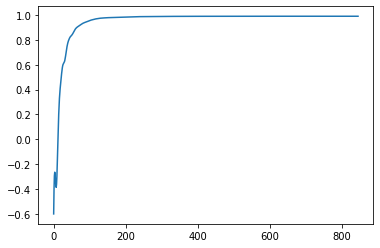

In [28]:
a = np.argmax(hist.history['val_r_square'])
print(a)
print(hist.history['val_r_square'][a])
# plot metrics
plt.plot(hist.history['val_r_square'])
plt.show()

46/46 [==============================] - 0s 560us/step - loss: 0.0323 - r_square: 0.9905
R2 test data: 0.9905019998550415


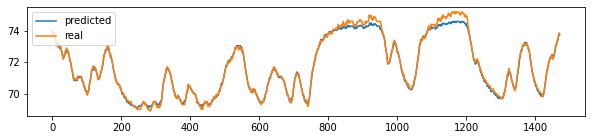

In [29]:
print("R2 test data:", model.evaluate(X_t, Y_t)[1])

plt.figure(figsize=(10,2))
plt.plot(model(X_t), label='predicted')
plt.plot(Y_t, label='real')
plt.legend()
plt.show()